In [46]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.dielectron_mass import dielectron_mass
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [ ]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = True
local = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'dielectron_mass_data'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples(year)

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['Data'], year, redirector=redirector_ucsd, small=False)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

#meta = get_sample_meta(fileset, samples)

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress

    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)

    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.dask_executor


if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')
    
else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        dielectron_mass(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()
    

samples_2018.yaml
I'm running now


Preprocessing:   0%|          | 0/813 [00:00<?, ?file/s]

Processing:   0%|          | 0/5553 [00:00<?, ?chunk/s]

In [4]:
output['totalEvents']['all']/1e6

1384.292955

In [7]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_fine_bins   = hist.Bin('pt', r'$p_{T}\ (GeV)$', 300, 0, 300)
pt_rebin       = hist.Bin('pt', r'$p_{T}\ (GeV)$', 75, 0, 150)
eta_bins       = hist.Bin('eta', r'$\eta $', np.array([0, 0.8, 1.479, 2.5]))
eta_rebin      = hist.Bin('eta', r'$\eta $', 25, -2.5, 2.5)    
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)
mass_bins      = hist.Bin('mass', r'$mass (GeV/c^2)$', 19, 48, 124)

# 1D Histograms

In [9]:
from yahist import Hist1D, Hist2D

In [34]:
def get_total(histos, keys):
        tmp = Hist1D.from_bincounts(np.zeros(len(histos[keys[0]].counts)), histos[keys[0]].edges, )
        for key in keys:
            tmp += histos[key]
        return tmp

def add_uncertainty(hist, ax, ratio=False):
    opts = {'step': 'post', 'label': 'Uncertainty', 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0, 'zorder':10.}
    
    if ratio:
        down = np.ones(len(hist.counts)) - hist.errors/hist.counts
        up = np.ones(len(hist.counts)) + hist.errors/hist.counts
    else:
        down = hist.counts-hist.errors
        up = hist.counts+hist.errors
    ax.fill_between(x=hist.edges, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)

In [ ]:
import gzip
import pickle
import cloudpickle

outname = 'dielectron_data_'+str(year)
os.system("mkdir -p histos/")
print('Saving output in %s...'%("histos/" + outname + ".pkl.gz"))
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(output, fout)
print('Done!')

In [5]:
path = 'histos/dielectron_mc_2018.pkl.gz'
with gzip.open(path) as fin:
    mc_output= pickle.load(fin)
    
path = 'histos/dielectron_data_2018.pkl.gz'
with gzip.open(path) as fin:
    output= pickle.load(fin)

In [32]:
tmp1 = output['dilep_mass1'].copy()
tmp1 = tmp1.rebin('mass', mass_bins)
tmp1 = tmp1.rebin('pt', pt_rebin)

h1 = Hist1D.from_bincounts(
    tmp1.sum('pt', 'dataset').values()[()].T,
    (tmp1.axis('mass').edges()),
    errors = np.sqrt(tmp1.sum('pt', 'dataset').values(sumw2=True)[()][1].T),
)

h2 = Hist1D.from_bincounts(
    tmp1.sum('mass', 'dataset').values()[()].T,
    (tmp1.axis('pt').edges()),
    errors = np.sqrt(tmp1.sum('mass', 'dataset').values(sumw2=True)[()][1].T),
)

tmp2 = mc_output['dilep_mass1'].copy()
tmp2 = tmp2.rebin('mass', mass_bins)
tmp2 = tmp2.rebin('pt', pt_rebin)

h1_DY = Hist1D.from_bincounts(
    tmp2.sum('pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('mass').edges()),
    errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h1_DY = h1_DY*6021.0*1000/100108281.94794683*60

h1_TT = Hist1D.from_bincounts(
    tmp2.sum('pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('mass').edges()),
    errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h1_TT = h1_TT*87.315*1000/4635769336.539396*60

h2_DY = Hist1D.from_bincounts(
    tmp2.sum('mass').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('pt').edges()),
    errors = np.sqrt(tmp2.sum('mass').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h2_DY = h2_DY*6021.0*1000/100108281.94794683*60

h2_TT = Hist1D.from_bincounts(
    tmp2.sum('mass').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('pt').edges()),
    errors = np.sqrt(tmp2.sum('mass').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h2_TT = h2_TT*87.315*1000/4635769336.539396*60


In [35]:
hists = {'mass_OS_data': h1,
         'mass_OS_DY':   h1_DY,
         'mass_OS_TT':   h1_TT,
}

hists['mass_OS_TT'].label = '$TT\ (OS)$'
hists['mass_OS_TT'].color = '#8AC926'

hists['mass_OS_DY'].label = '$DY\ (OS)$'
hists['mass_OS_DY'].color = '#FFCA3A'

keys = ['mass_OS_DY', 'mass_OS_TT']

total_mc = get_total(hists, keys)

ratio = (hists['mass_OS_data']).divide(hists['mass_OS_TT']+hists['mass_OS_DY'])

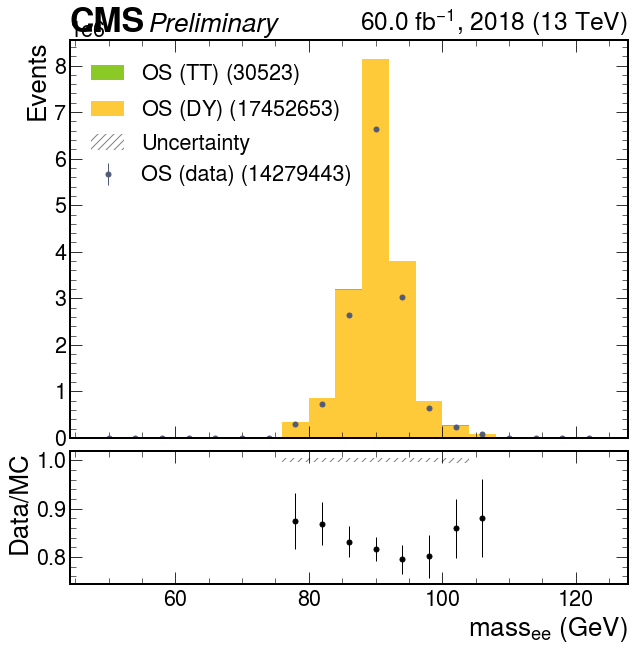

In [43]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['mass_OS_DY'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['mass_OS_data'].counts],
    hists['mass_OS_data'].edges,
    w2=[hists['mass_OS_data'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['mass_OS_data'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$mass_{ee}\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)


ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zmass_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zmass_data.pdf')

In [15]:
hists = {'pt_OS_data':   h2,
         'pt_OS_DY':     h2_DY,
         'pt_OS_TT':     h2_TT,
        }

hists['pt_OS_TT'].label = '$TT\ (OS)$'
hists['pt_OS_TT'].color = '#8AC926'

hists['pt_OS_DY'].label = '$DY\ (OS)$'
hists['pt_OS_DY'].color = '#FFCA3A'

keys = ['pt_OS_TT', 'pt_OS_DY']

total_mc = get_total(hists, keys)

ratio = (hists['pt_OS_data']).divide(hists['pt_OS_TT']+hists['pt_OS_DY'])

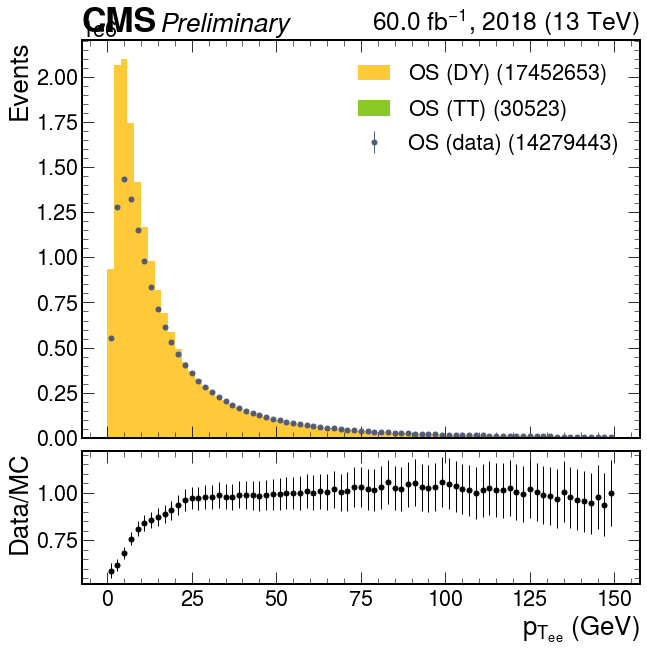

In [16]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['pt_OS_DY'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['pt_OS_data'].counts],
    hists['pt_OS_data'].edges,
    w2=[hists['pt_OS_data'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['pt_OS_data'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T_{ee}}\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zpt_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zpt_data.pdf')

In [17]:
tmp1 = output['electron_data1'].copy()
tmp1 = tmp1.rebin('pt', pt_rebin)
tmp1 = tmp1.rebin('eta', eta_rebin)

tmp2 = output['electron_data2'].copy()
tmp2 = tmp2.rebin('pt', pt_rebin)
tmp2 = tmp2.rebin('eta', eta_rebin)

tmp3 = mc_output['electron_data1'].copy()
tmp3 = tmp3.rebin('pt', pt_rebin)
tmp3 = tmp3.rebin('eta', eta_rebin)


tmp4 = mc_output['electron_data2'].copy()
tmp4 = tmp4.rebin('pt', pt_rebin)
tmp4 = tmp4.rebin('eta', eta_rebin)


h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset', 'phi', 'eta').values()[()].T,
    (tmp1.axis('pt').edges()),
    errors = np.sqrt(tmp1.sum('dataset', 'phi', 'eta').values(sumw2=True)[()][1].T),
)

h2 = Hist1D.from_bincounts(
    tmp2.sum('dataset', 'phi', 'eta').values()[()].T,
    (tmp2.axis('pt').edges()),
    errors = np.sqrt(tmp2.sum('dataset', 'phi', 'eta').values(sumw2=True)[()][1].T),
)
    
h3 = Hist1D.from_bincounts(
    tmp1.sum('dataset', 'phi', 'pt').values()[()].T,
    (tmp1.axis('eta').edges()),
    errors = np.sqrt(tmp1.sum('dataset', 'phi', 'pt').values(sumw2=True)[()][1].T),
)
    
    
h4 = Hist1D.from_bincounts(
    tmp2.sum('dataset', 'phi', 'pt').values()[()].T,
    (tmp2.axis('eta').edges()),
    errors = np.sqrt(tmp2.sum('dataset', 'phi', 'pt').values(sumw2=True)[()][1].T),
)
    
h5 = Hist1D.from_bincounts(
    tmp1.sum('dataset', 'eta', 'pt').values()[()].T,
    (tmp1.axis('phi').edges()),
    errors = np.sqrt(tmp1.sum('dataset', 'eta', 'pt').values(sumw2=True)[()][1].T),
)
    
    
h6 = Hist1D.from_bincounts(
    tmp2.sum('dataset', 'eta', 'pt').values()[()].T,
    (tmp2.axis('phi').edges()),
    errors = np.sqrt(tmp2.sum('dataset', 'eta', 'pt').values(sumw2=True)[()][1].T),
)




h1_DY = Hist1D.from_bincounts(
    tmp3.sum('phi', 'eta').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('pt').edges()),
    errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h2_DY = Hist1D.from_bincounts(
    tmp4.sum('phi', 'eta').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('pt').edges()),
    errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
h3_DY = Hist1D.from_bincounts(
    tmp3.sum('phi', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('eta').edges()),
    errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
    
h4_DY = Hist1D.from_bincounts(
    tmp4.sum('phi', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('eta').edges()),
    errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
h5_DY = Hist1D.from_bincounts(
    tmp3.sum('eta', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('phi').edges()),
    errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
    
h6_DY = Hist1D.from_bincounts(
    tmp4.sum('eta', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('phi').edges()),
    errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h1_DY = h1_DY*6021.0*1000/100108281.94794683*60
h2_DY = h2_DY*6021.0*1000/100108281.94794683*60
h3_DY = h3_DY*6021.0*1000/100108281.94794683*60
h4_DY = h4_DY*6021.0*1000/100108281.94794683*60
h5_DY = h5_DY*6021.0*1000/100108281.94794683*60
h6_DY = h6_DY*6021.0*1000/100108281.94794683*60


h1_TT = Hist1D.from_bincounts(
    tmp3.sum('phi', 'eta').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('pt').edges()),
    errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h2_TT = Hist1D.from_bincounts(
    tmp4.sum('phi', 'eta').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('pt').edges()),
    errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
h3_TT = Hist1D.from_bincounts(
    tmp3.sum('phi', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('eta').edges()),
    errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
    
h4_TT = Hist1D.from_bincounts(
    tmp4.sum('phi', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('eta').edges()),
    errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
h5_TT = Hist1D.from_bincounts(
    tmp3.sum('eta', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('phi').edges()),
    errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)
    
    
h6_TT = Hist1D.from_bincounts(
    tmp4.sum('eta', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('phi').edges()),
    errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
)

h1_TT = h1_TT*87.315*1000/4635769336.539396*60
h2_TT = h2_TT*87.315*1000/4635769336.539396*60
h3_TT = h3_TT*87.315*1000/4635769336.539396*60
h4_TT = h4_TT*87.315*1000/4635769336.539396*60
h5_TT = h5_TT*87.315*1000/4635769336.539396*60
h6_TT = h6_TT*87.315*1000/4635769336.539396*60

In [19]:
hists = {
    'pt_OS_data1': h1,
    'pt_OS_DY1': h1_DY,
    'pt_OS_TT1': h1_TT,
}

hists['pt_OS_DY1'].label = '$OS\ (DY)$'
hists['pt_OS_DY1'].color = '#FFCA3A'

hists['pt_OS_TT1'].label = '$OS\ (TT)$'
hists['pt_OS_TT1'].color = '#8AC926'

keys = ['pt_OS_DY1', 'pt_OS_TT1']

total_mc = get_total(hists, keys)

ratio = (hists['pt_OS_data1']).divide(hists['pt_OS_TT1']+hists['pt_OS_DY1'])

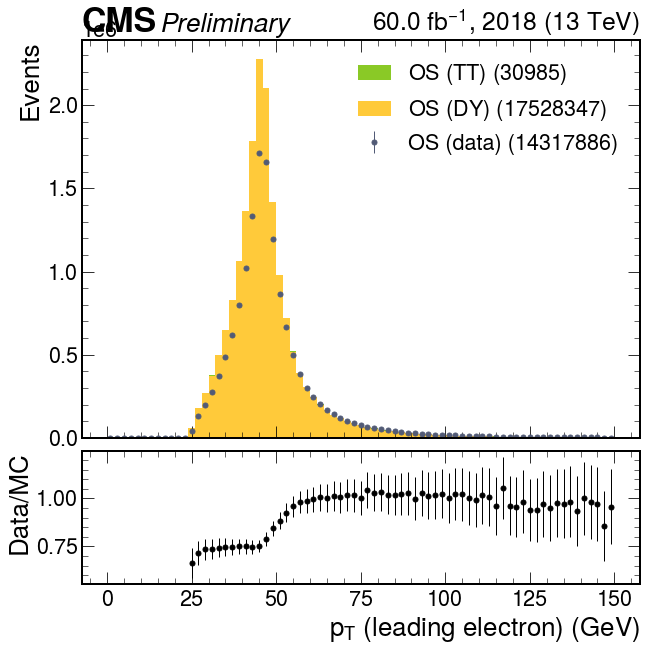

In [20]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['pt_OS_DY1'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['pt_OS_data1'].counts],
    hists['pt_OS_data1'].edges,
    w2=[hists['pt_OS_data1'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('OS (data)', np.sum(hists['pt_OS_data1'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T}\ (leading\ electron)\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(l)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(l)_data.pdf')

In [21]:
hists ={'pt_OS_data2': h2,
        'pt_OS_DY2': h2_DY,
        'pt_OS_TT2': h2_TT,
}   

hists['pt_OS_DY2'].label = '$OS\ (DY)$'
hists['pt_OS_DY2'].color = '#FFCA3A'

hists['pt_OS_TT2'].label = '$OS\ (TT)$'
hists['pt_OS_TT2'].color = '#8AC926'

keys = ['pt_OS_DY2', 'pt_OS_TT1']

total_mc = get_total(hists, keys)

ratio = (hists['pt_OS_data2']).divide(hists['pt_OS_TT2']+hists['pt_OS_DY2'])

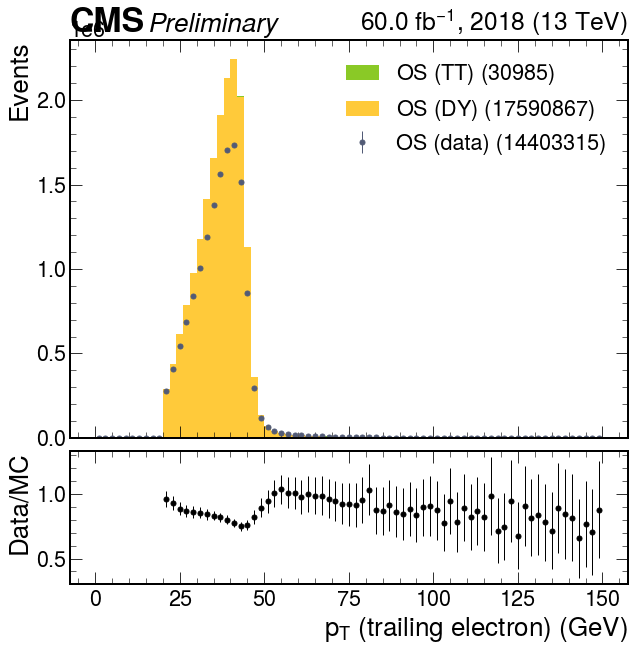

In [22]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['pt_OS_DY2'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['pt_OS_data2'].counts],
    hists['pt_OS_data2'].edges,
    w2=[hists['pt_OS_data2'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('OS (data)', np.sum(hists['pt_OS_data2'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T}\ (trailing\ electron)\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(t)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(t)_data.pdf')

In [23]:
hists = {'eta_OS_data1': h3,
         'eta_OS_DY1': h3_DY,
         'eta_OS_TT1': h3_TT,
}

hists['eta_OS_DY1'].label = '$OS\ (DY)$'
hists['eta_OS_DY1'].color = '#FFCA3A'


hists['eta_OS_TT1'].label = '$OS\ (TT)$'
hists['eta_OS_TT1'].color = '#8AC926'


keys = ['eta_OS_DY1', 'eta_OS_TT1']

total_mc = get_total(hists, keys)

ratio = (hists['eta_OS_data1']).divide(hists['eta_OS_TT1']+hists['eta_OS_DY1'])

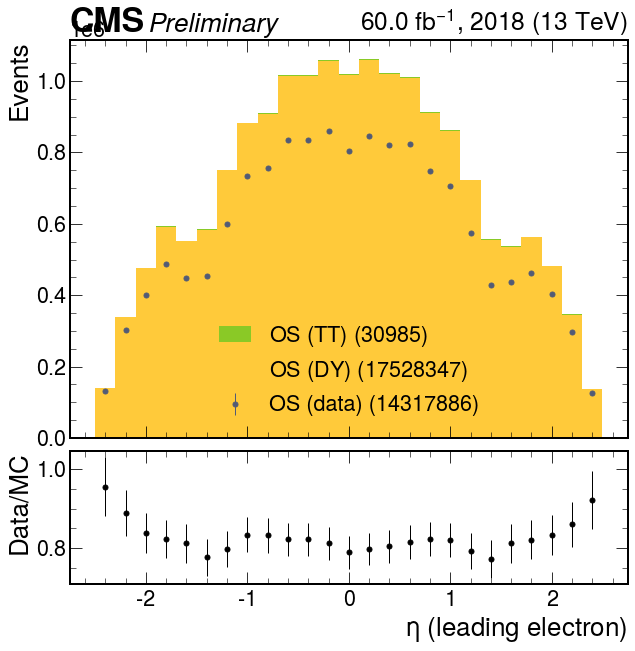

In [24]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['eta_OS_DY1'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['eta_OS_data1'].counts],
    hists['eta_OS_data1'].edges,
    w2=[hists['eta_OS_data1'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('OS (data)', np.sum(hists['eta_OS_data1'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.95,1.55)
rax.set_xlabel(r'$\eta\ (leading\ electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(l)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(l)_data.pdf')

In [25]:
hists = {'eta_OS_data2': h4,
         'eta_OS_DY2': h4_DY,
         'eta_OS_TT2': h4_TT,
}

hists['eta_OS_DY2'].label = '$OS\ (DY)$'
hists['eta_OS_DY2'].color = '#FFCA3A'

hists['eta_OS_TT2'].label = '$OS\ (TT)$'
hists['eta_OS_TT2'].color = '#8AC926'

keys = ['eta_OS_DY2', 'eta_OS_TT2']

total_mc = get_total(hists, keys)

ratio = (hists['eta_OS_data2']).divide(hists['eta_OS_TT2']+hists['eta_OS_DY2'])

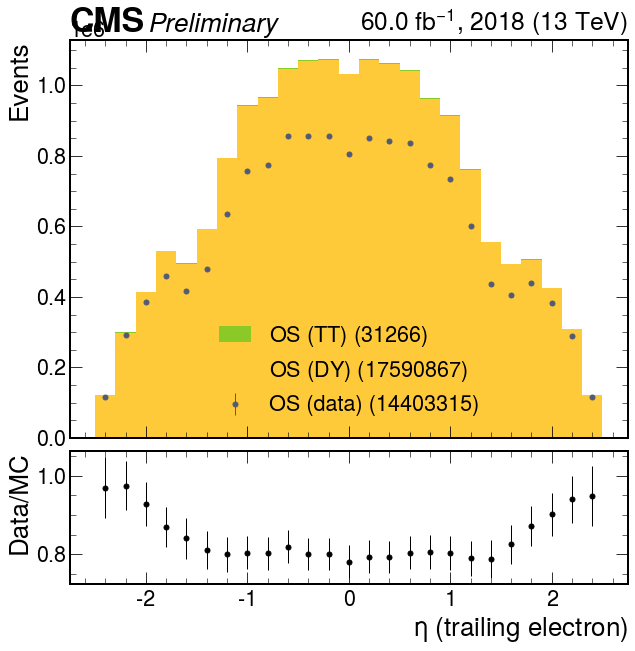

In [26]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['eta_OS_DY2'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['eta_OS_data2'].counts],
    hists['eta_OS_data2'].edges,
    w2=[hists['eta_OS_data2'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('OS (data)', np.sum(hists['eta_OS_data2'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.95,1.55)
rax.set_xlabel(r'$\eta\ (trailing\ electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(t)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(t)_data.pdf')

In [28]:
hists = {'phi_OS_data1': h5,
         'phi_OS_DY1': h5_DY,
         'phi_OS_TT1': h5_TT,
}

hists['phi_OS_DY1'].label = '$OS\ (DY)$'
hists['phi_OS_DY1'].color = '#FFCA3A'

hists['phi_OS_TT1'].label = '$OS\ (TT)$'
hists['phi_OS_TT1'].color = '#8AC926'

keys = ['phi_OS_DY1', 'phi_OS_TT1']

total_mc = get_total(hists, keys)

ratio = (hists['phi_OS_data1']).divide(hists['phi_OS_TT1']+hists['phi_OS_DY1'])

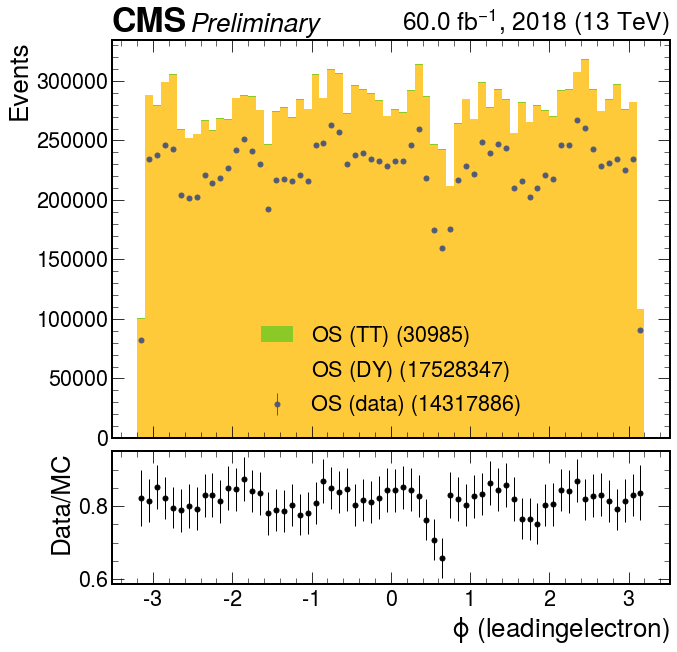

In [29]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['phi_OS_DY1'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['phi_OS_data1'].counts],
    hists['phi_OS_data1'].edges,
    w2=[hists['phi_OS_data1'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('OS (data)', np.sum(hists['phi_OS_data1'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.95,1.55)
rax.set_xlabel(r'$\phi\ (leading electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(l)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(l)_data.pdf')

In [30]:
hists = {'phi_OS_data2': h6,
         'phi_OS_DY2': h6_DY,
         'phi_OS_TT2': h6_TT,
}

hists['phi_OS_DY2'].label = '$OS\ (DY)$'
hists['phi_OS_DY2'].color = '#FFCA3A'

hists['phi_OS_TT2'].label = '$OS\ (TT)$'
hists['phi_OS_TT2'].color = '#8AC926'

keys = ['phi_OS_DY2', 'phi_OS_TT2']

total_mc = get_total(hists, keys)

ratio = (hists['phi_OS_data2']).divide(hists['phi_OS_TT2']+hists['phi_OS_DY2'])

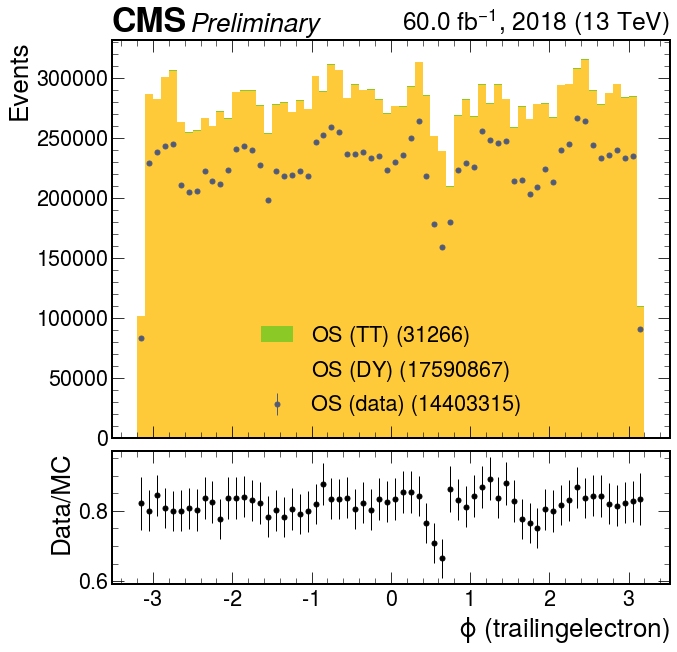

In [31]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['phi_OS_DY2'].edges,
    w2=[hists[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['phi_OS_data2'].counts],
    hists['phi_OS_data2'].edges,
    w2=[hists['phi_OS_data2'].errors],
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('OS (data)', np.sum(hists['phi_OS_data2'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[ratio.errors],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.95,1.55)
rax.set_xlabel(r'$\phi\ (trailing electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(t)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(t)_data.pdf')